In [1]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(36)

# Model Selection via Perfect Monte Carlo 

Consider the following probabilistic model:

$$
p(x) = \mathcal{N}(x; 5, 0.01)
$$

$$
p(y_i \mid x) = \mathcal{N}(y_i; \theta x, 0.05)
$$

for $i = 1, \ldots, T$, where $y_i$ are conditionally independent given $x$.

We have a dataset denoted by $y_{1:T}$, with $T = 100$.

The marginal likelihood is

$$
p_\theta(y_{1:T}) = \int p_\theta(y_{1:T} \mid x)\, p(x)\, dx
$$

where the $\theta$-dependence is shown explicitly to emphasise that the marginal likelihood is a function of $\theta$.

Given samples from the prior $p(x)$, the test function is

$$
\varphi(x) = p_\theta(y_{1:T} \mid x)
$$

We first write the log-likelihood function of $y_{1:T}$:

$$
\log p_\theta(y_{1:T} \mid x)
$$

This is the joint likelihood of conditionally i.i.d. observations $y_i$ given $x$.

The function will take as inputs:

- the dataset vector `y` (loaded from `y_perfect_mc.txt`)
- $\theta$ (scalar)
- $x$ (scalar)
- `sig` (likelihood variance, given as $0.05$, but left as a variable)

Since the observations are independent, the log-likelihood is a sum of individual log-likelihoods:

$$
\log p_\theta(y_{1:T} \mid x)
=
\sum_{i=1}^{T}
\log \mathcal{N}(y_i; \theta x, \sigma^2)
$$


In [3]:
y = np.loadtxt('y_perfect_mc.txt')
y = np.array(y, dtype=np.float64)

def log_likelihood(y, x, theta, sig):
 # Sample mean
 ybar = np.sum(y) / len(y)
 # Sum of squares of y_i
 ssquared_y = np.sum(y**2)
 # product of T = 100 marginal likelihoods
 return 100 * (- 0.5 * np.log(2 * np.pi) - 0.5 * np.log(sig)) - (ssquared_y / (2 * sig))\
 - (50 * theta ** 2 * x ** 2) / (sig) + (100 * theta * x * ybar) / (sig)

Next, we write a log-sum-exp function. Let $\mathbf{v}$ be a vector of log-quantities and suppose we want to compute

$$
\log \sum_{i=1}^{N} \exp(v_i),
$$

where

$$
\mathbf{v} = (v_1, \ldots, v_N).
$$

This quantity can be written in a numerically stable form as

$$
\log \sum_{i=1}^{N} \exp(v_i)
=
\log \sum_{i=1}^{N} \exp(v_i - v_{\max}) + v_{\max},
$$

where

$$
v_{\max} = \max_{i = 1, \ldots, N} v_i.
$$

We prooced by implementing this as a function which takes a vector of log-values and returns the log of the sum of exponentials of the input values.


In [4]:
def logsumexp(v):
 v_sum = np.sum(np.exp(v - max(v)))
 return np.log(v_sum) + max(v)

We now implement the log-marginal likelihood estimator.

We implement a function that returns the **log of the Monte Carlo estimator** derived above.

The function will take as input:

- the dataset vector `y`
- the parameter $\theta$ (scalar)
- `x_samples` (a NumPy array containing $N$ Monte Carlo samples)
- a variance parameter `sig` (scalar) for the joint log-likelihood
  $$
  \log p_\theta(y_{1:T} \mid x),
  $$
  which will be used in the `log_likelihood` function (set to $0.05$)

The log of the Monte Carlo estimator of the marginal likelihood takes the form

$$
\log \left(
\frac{1}{N}
\sum_{i=1}^{N}
p_\theta(y_{1:T} \mid x^{(i)})
\right).
$$

We must use the identity

$$
p_\theta(y_{1:T} \mid x^{(i)})
=
\exp\left(
\log p_\theta(y_{1:T} \mid x^{(i)})
\right)
$$

to obtain a **log-sum-exp structure**, i.e. a log and sum (over particles) of exponentials of log-likelihood values, where
$i = 1, \ldots, N$ and $x^{(i)}$ are the Monte Carlo samples, being careful not to forget the $\frac{1}{N}$ term.

Therefore, we:

- use the log-likelihood function above to compute
  $$
  \log p_\theta(y_{1:T} \mid x^{(i)})
  $$
  for each $i = 1, \ldots, N$
- use the **logsumexp** function from on these values
- subtract $\log N$ to obtain the estimate of the **log marginal likelihood**

In [6]:
def log_marginal_likelihood(y, theta, x_samples, sig):
 v_MC = log_likelihood(y, x_samples, theta, sig)
 return logsumexp(v_MC)

We will now try to find the most likely value of $\theta$.

We run our `log_marginal_likelihood` function for a range of $\theta$ values. **For every $\theta$ value**, we need to sample **$N$ new samples from the prior** , i.e. we do **not** reuse the same samples).

We compute the Monte Carlo estimator

$$
\log \hat{\pi}^{N}_{MC} \approx \log p_\theta(y_{1:T})
$$

for the $\theta$-range given below.

Finally, we **plot the log marginal likelihood estimator as a function of $\theta$**.

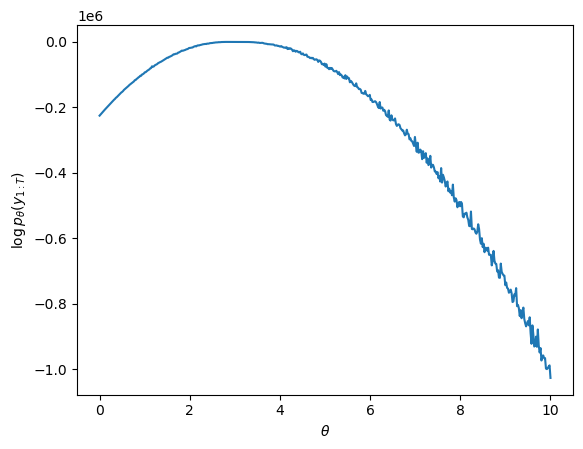

In [12]:
sig = 0.05
sig_prior = 0.01
mu_prior = 5.0
N = 1000
theta_range = np.linspace(0, 10, 500)
log_ml_list = np.array([])

for n in range(len(theta_range)):
 # Generate normal random samples for each step in the loop
 x_samples = np.random.normal(mu_prior, np.sqrt(sig_prior), N)
 # Assign variable name and append to list
 log_ml = log_marginal_likelihood(y, x_samples, theta_range[n], sig)
 log_ml_list = np.append(log_ml_list, log_ml)

plt.plot(theta_range, log_ml_list)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\log p_\theta(y_{1:T})$')
plt.show()